# Car Price Prediction Using Machine Learning
Project Overview

This project focuses on predicting the **selling price of cars** based on various features such as engine size, fuel type, brand, dimensions, and performance indicators. 

The goal is to:
- Help buyers estimate a fair price based on specifications
- Assist dealers in automated pricing models
- Explore which features most influence car prices

We apply various regression models — from **Linear Regression** to advanced **Ensemble Learning** — and evaluate them using multiple error metrics and visual interpretations.

We will use Python libraries like pandas, numpy, matplotlib, seaborn for data analysis and visualization,
and scikit-learn for machine learning models.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
data = pd.read_csv('../data/CarPrice_Assignment.csv')
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


Load and Inspect Data

In [4]:
data.shape

(205, 26)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

##  Dataset Description

- Total Records: **205**
- Target Variable: `price`
- Source: Kaggle 

###  Key Features:
| Feature              | Description                                  |
|----------------------|----------------------------------------------|
| `enginesize`         | Size of engine (cc)                          |
| `curbweight`         | Weight of car without passengers             |
| `horsepower`         | Horsepower output                            |
| `citympg`            | Fuel efficiency in city                      |
| `highwaympg`         | Fuel efficiency on highway                   |
| `carbody`, `brand`, etc. | Categorical features                     |
| `price`              | **Target variable** — selling price in USD   |

>  No missing values. Some categorical variables should be cleaned and encoded.

##  Data Preprocessing

To prepare the dataset for modeling, the following steps were applied:

1. **Dropped irrelevant or low-impact features** (e.g., `symboling`, `peakrpm`, `stroke`, `compressionratio`)
2. **Corrected typos** in brand names (e.g., `porcshce` ➝ `porsche`)
3. **One-hot encoded** categorical features (`carbody`, `drivewheel`, `brand`, etc.)
4. **Scaled numerical values** using `StandardScaler` to ensure consistency for linear models


In [6]:
# Extract brand
data['CarBrand'] = data['CarName'].str.split(' ').str[0]
data = data.drop('CarName', axis=1)

In [7]:
data = data.drop('car_ID', axis=1)


Visualize relationships between features and selling price


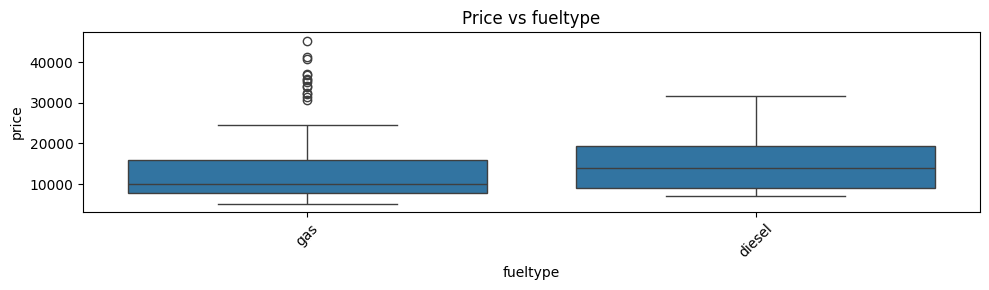

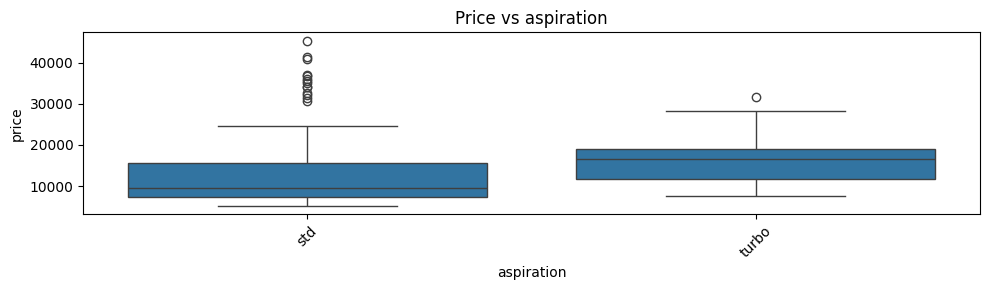

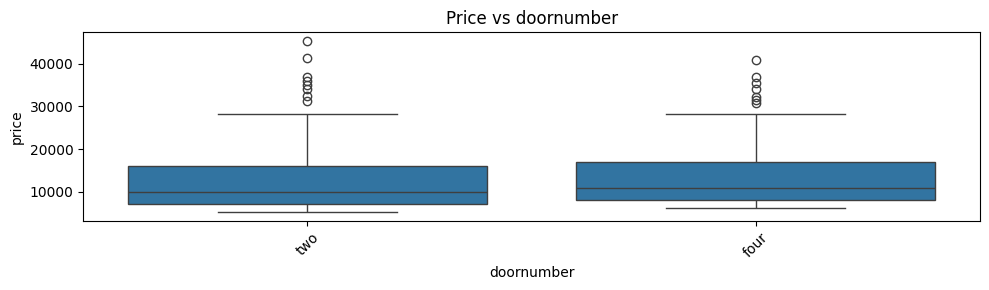

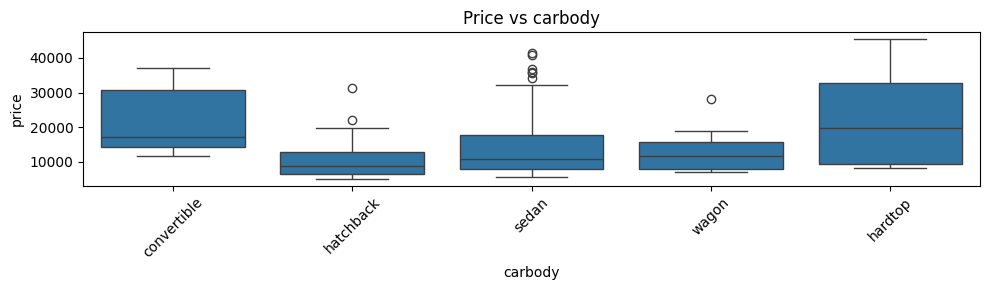

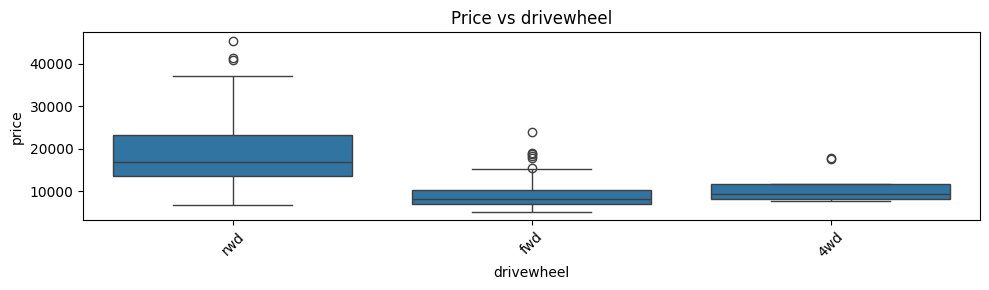

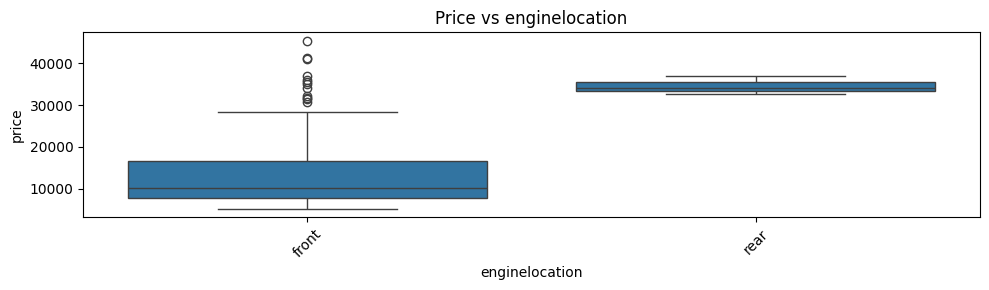

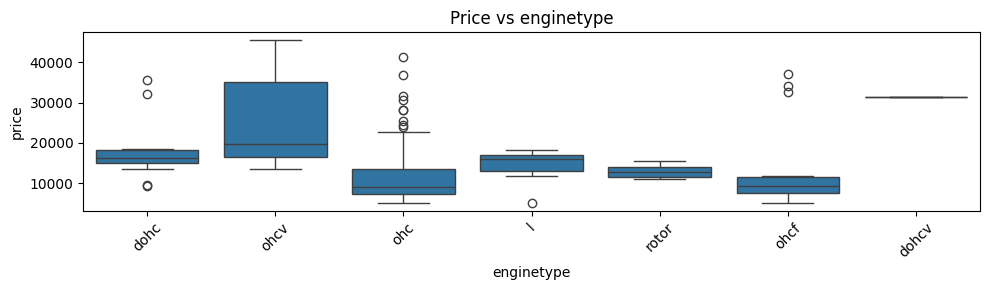

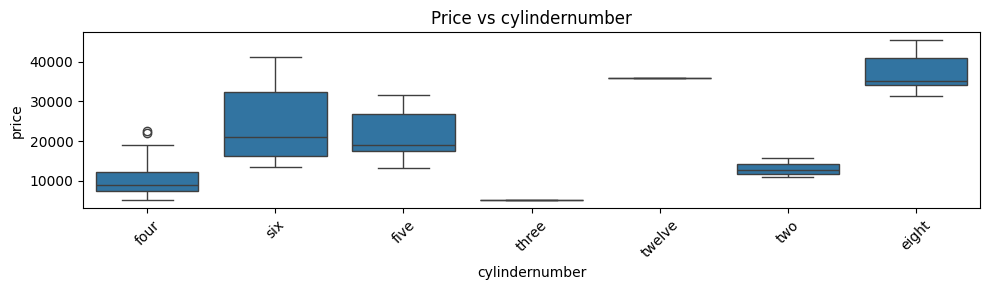

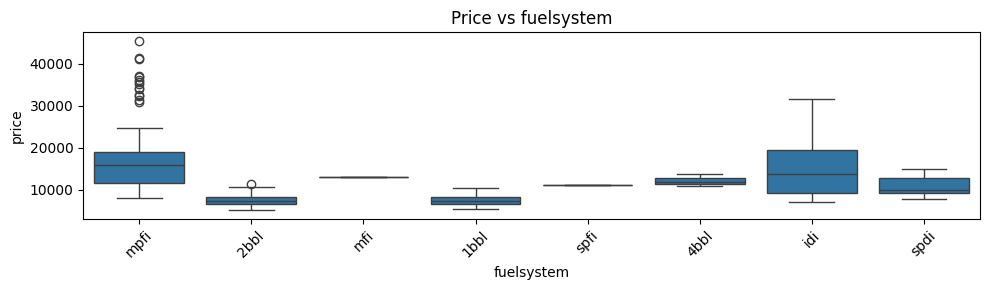

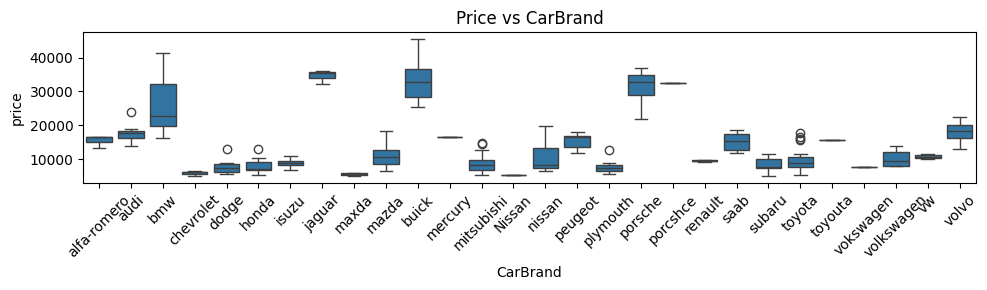

In [8]:
object_columns = data.select_dtypes(include='object').columns
for col in object_columns:
    plt.figure(figsize=(10,3))
    sns.boxplot(x=col, y='price', data=data)
    plt.xticks(rotation=45)
    plt.title(f"Price vs {col}")
    plt.tight_layout()
    plt.show()

From the exploratory data analysis, we observed the following:

- **Engine size, horsepower, and curb weight** show a strong positive correlation with car price — heavier and more powerful cars are generally more expensive.
- **Drive wheel (drivewheel)** type has a clear impact: RWD cars tend to be priced higher than FWD and 4WD, suggesting performance or premium positioning.
- **Car body type (carbody)** is important: convertibles and hardtops are usually priced higher, while hatchbacks and sedans are generally cheaper.
- **Fuel type** has a small effect — diesel cars are slightly more expensive than gas ones.
- **Engine location** matters significantly — rear-engine cars are priced much higher, though they are rare (likely high-end sports models).
- Some features like **fuelsystem** and **enginetype** showed too much noise or too many categories to extract clear patterns and were not prioritized for modeling.


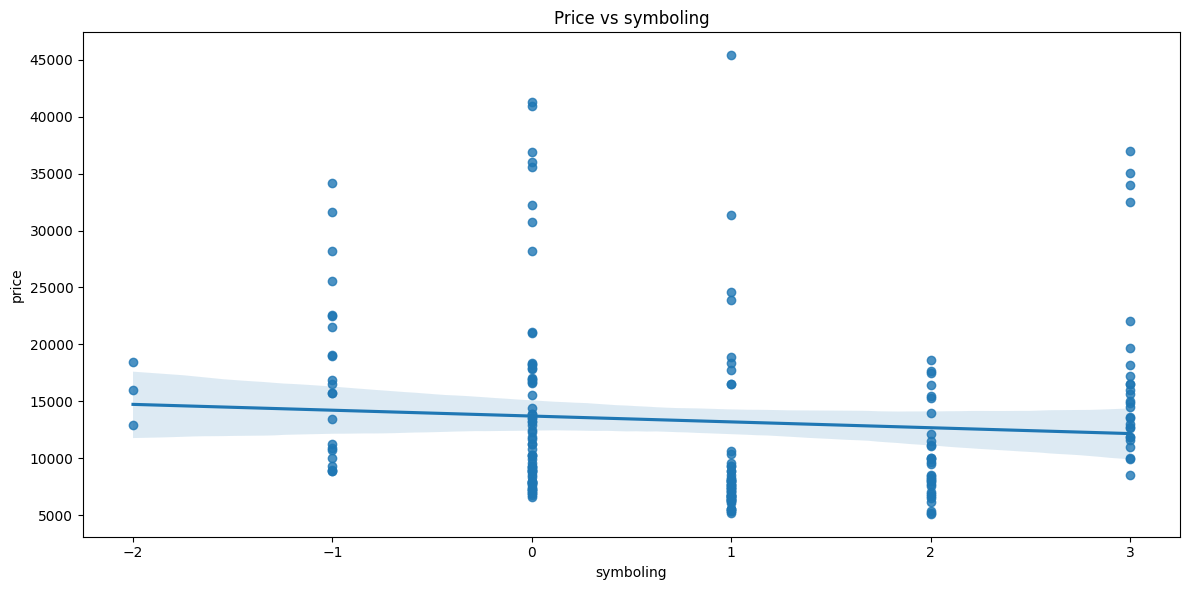

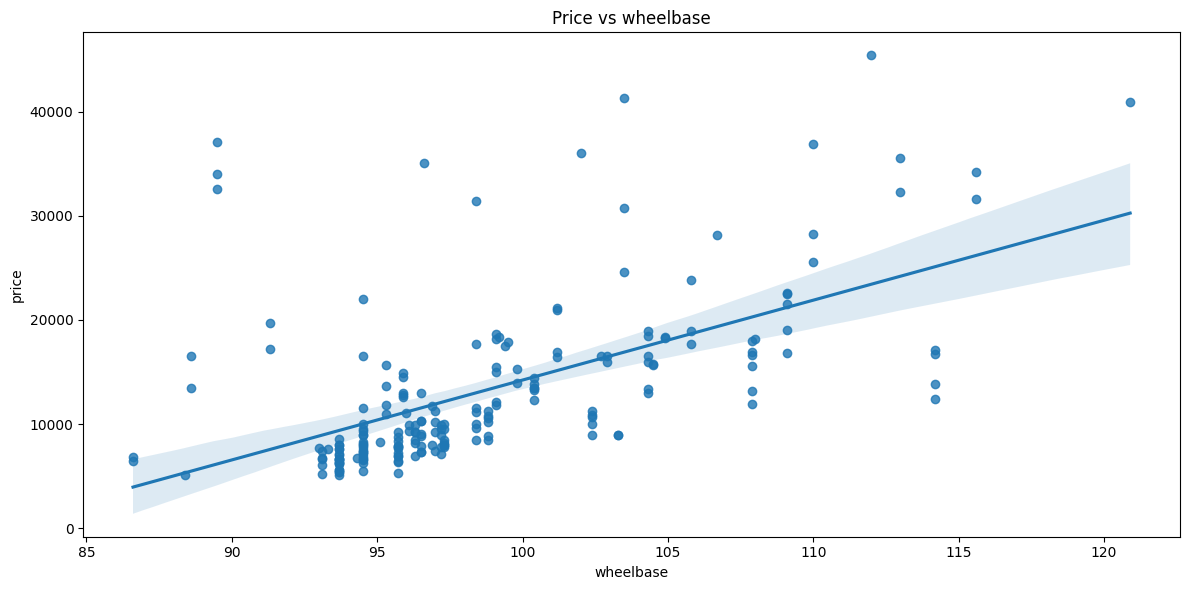

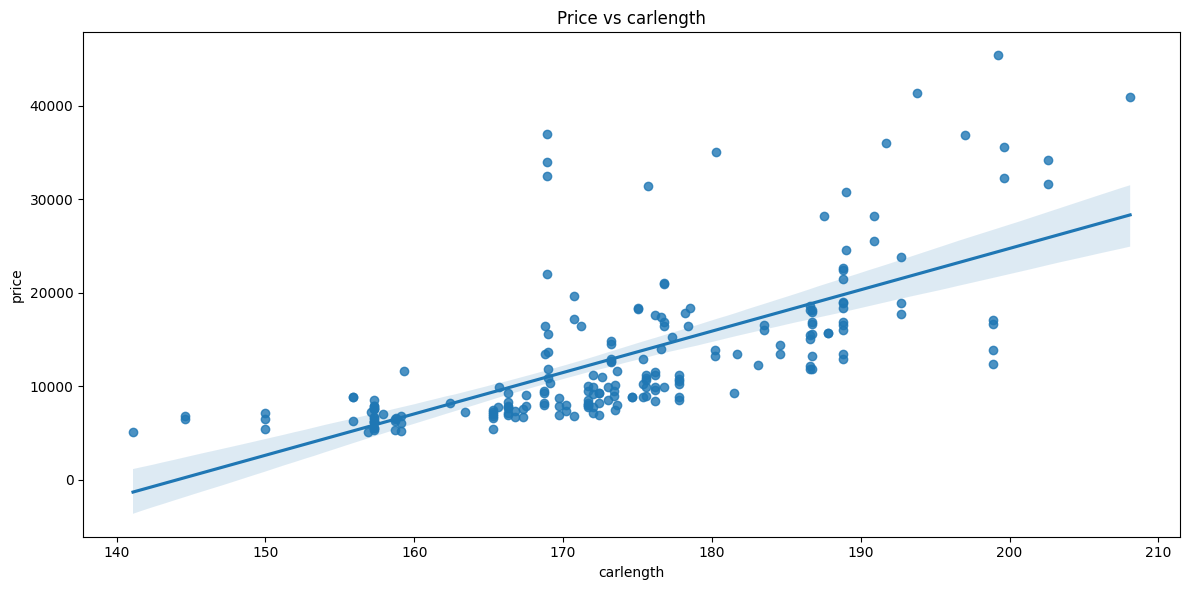

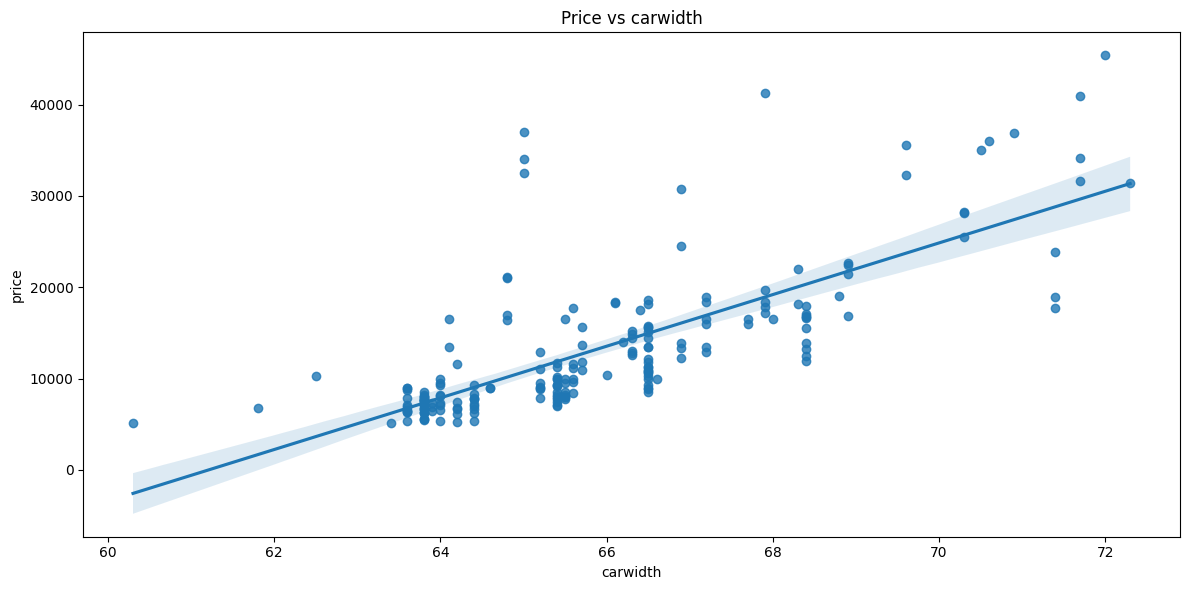

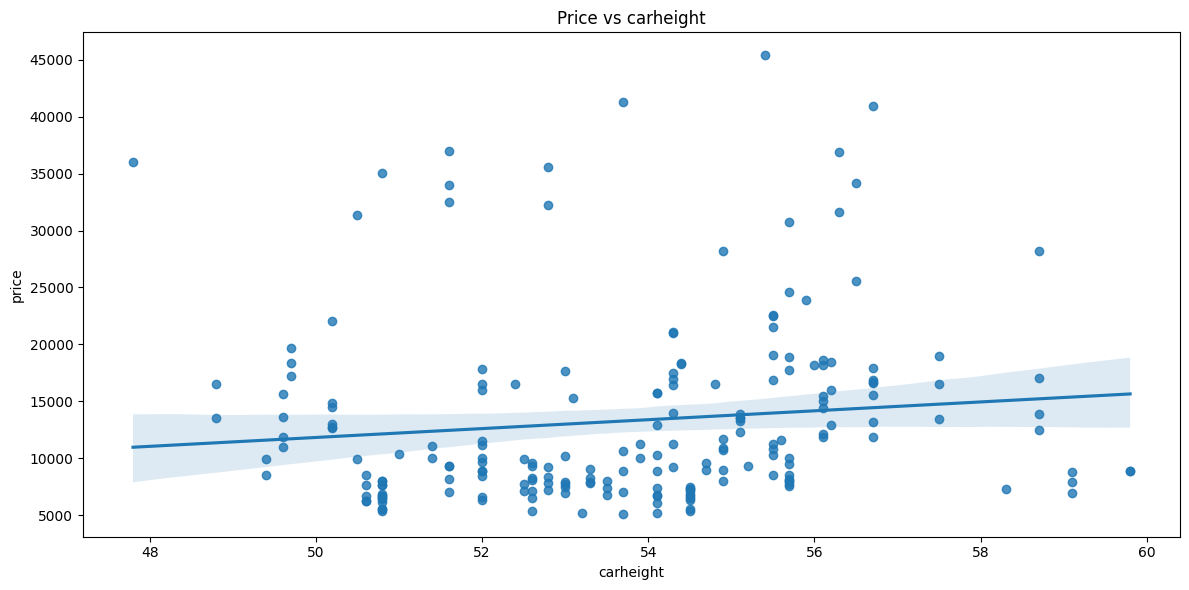

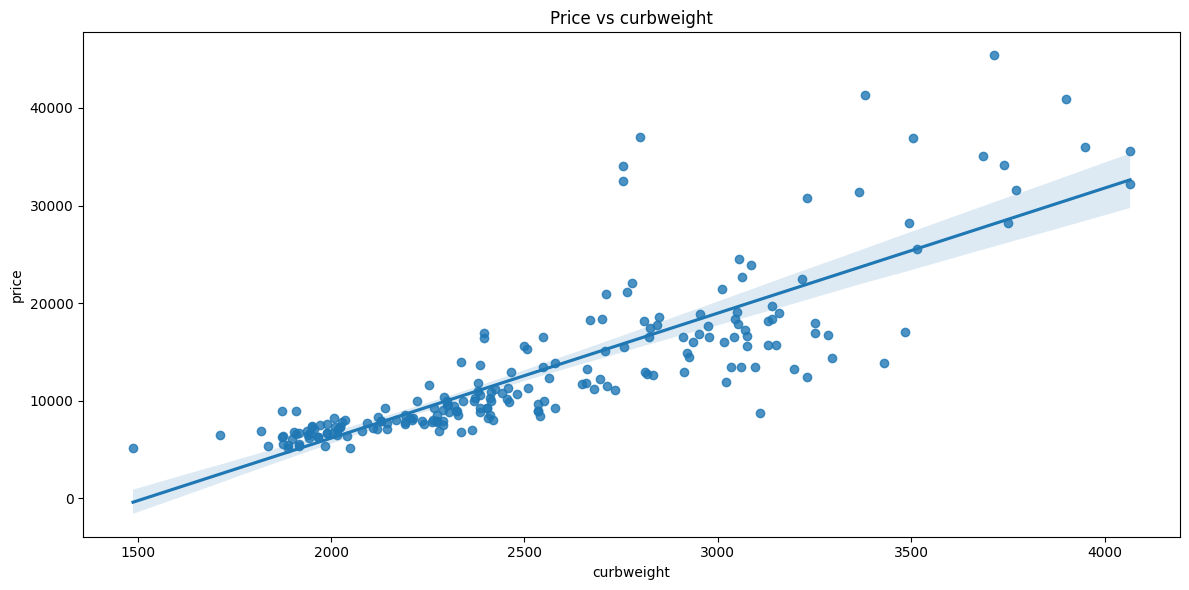

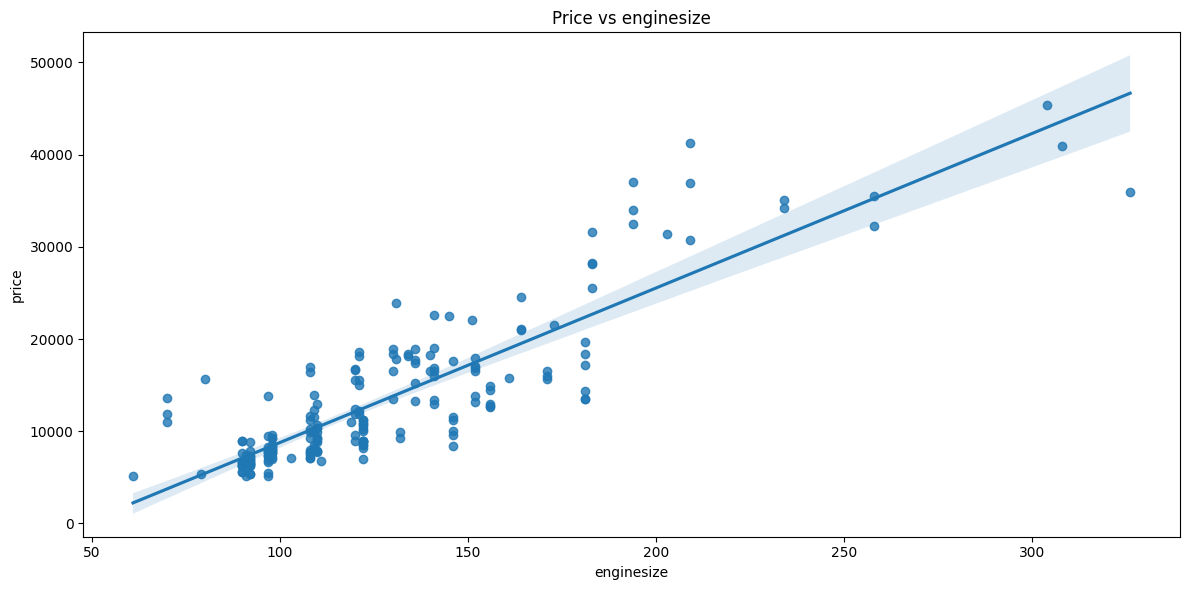

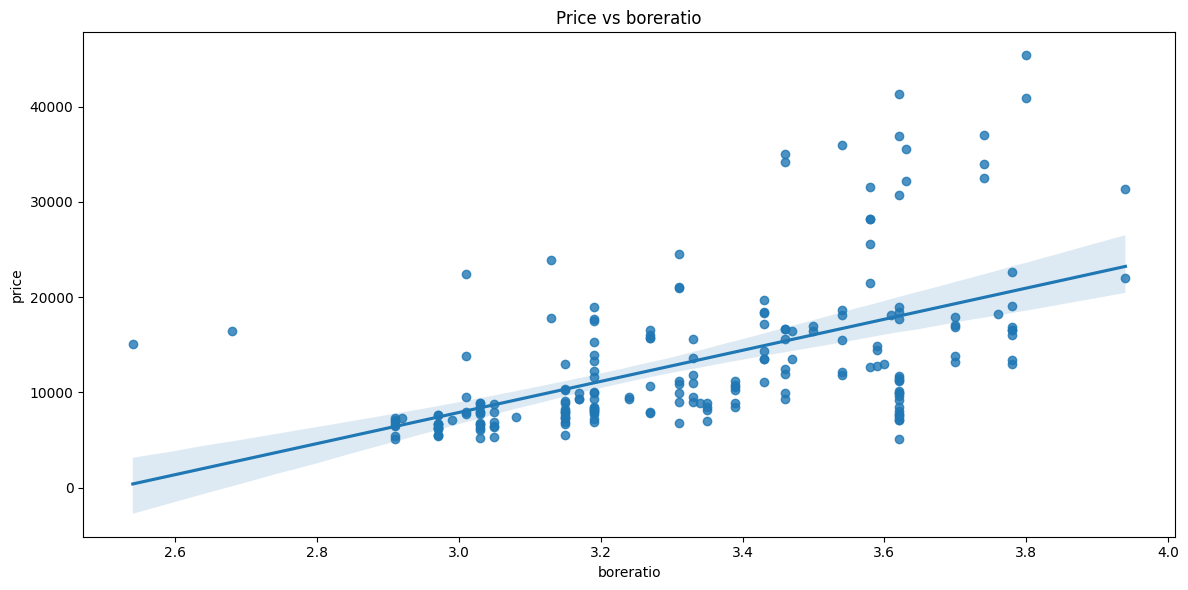

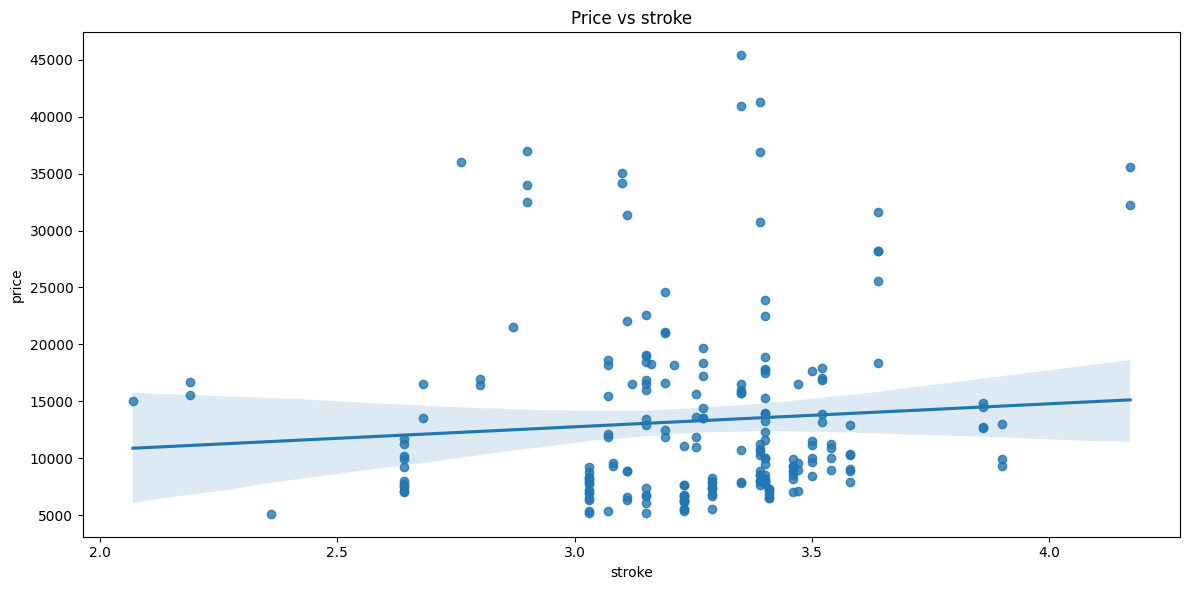

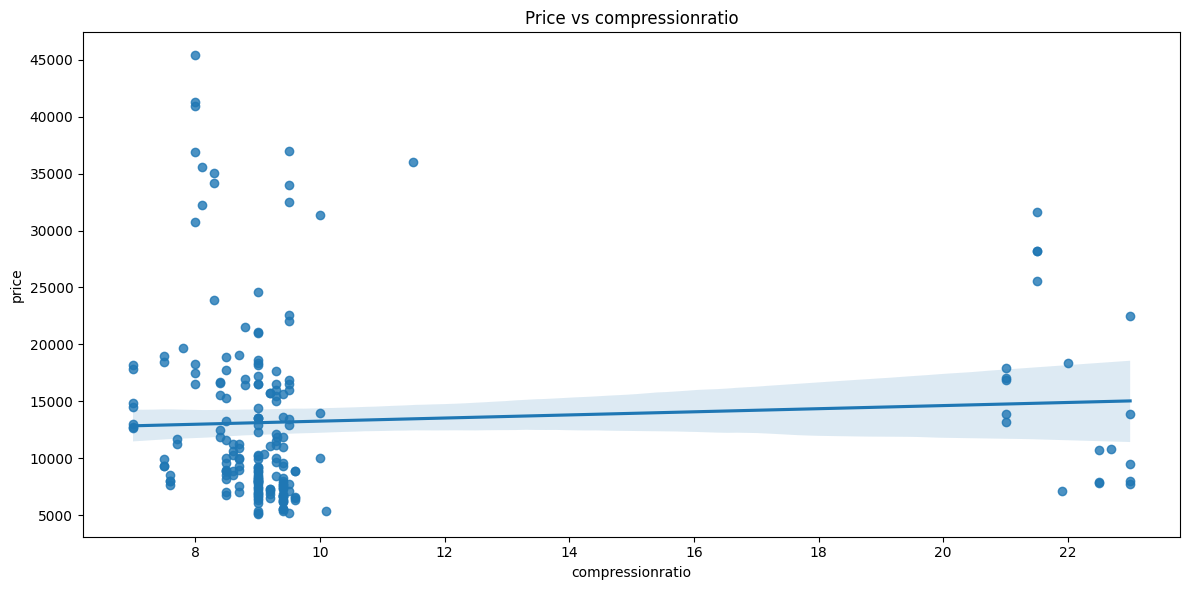

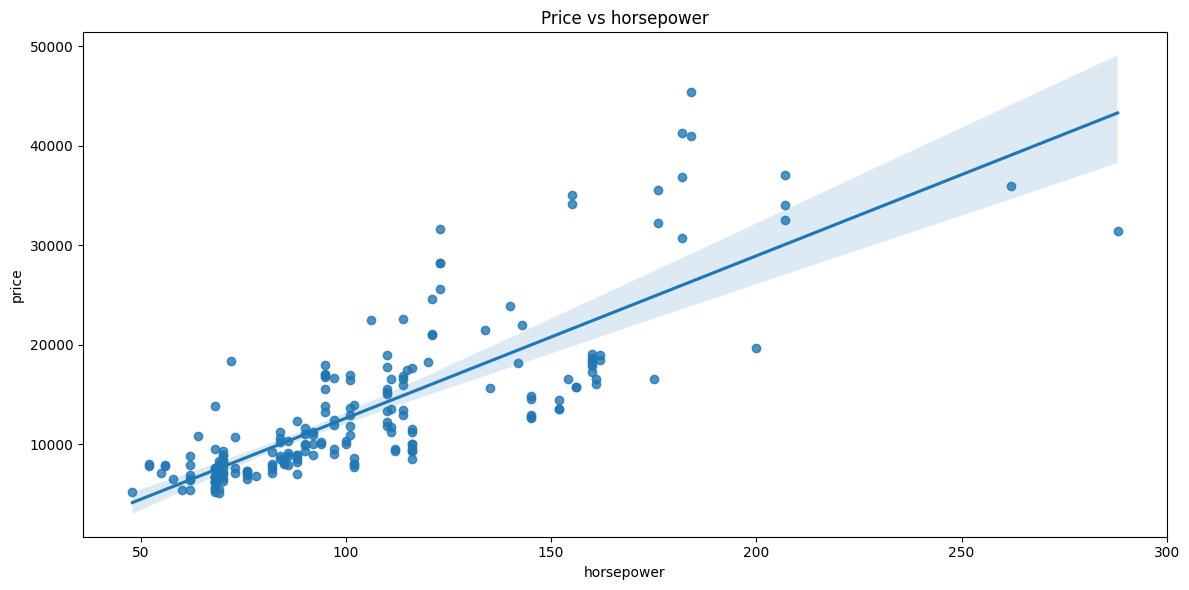

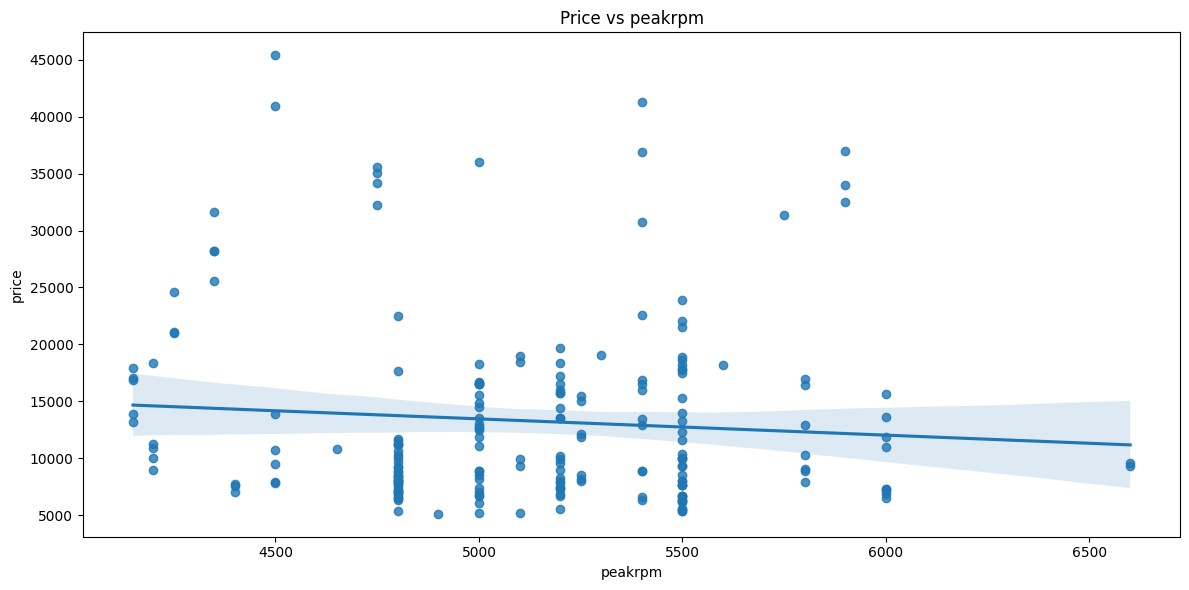

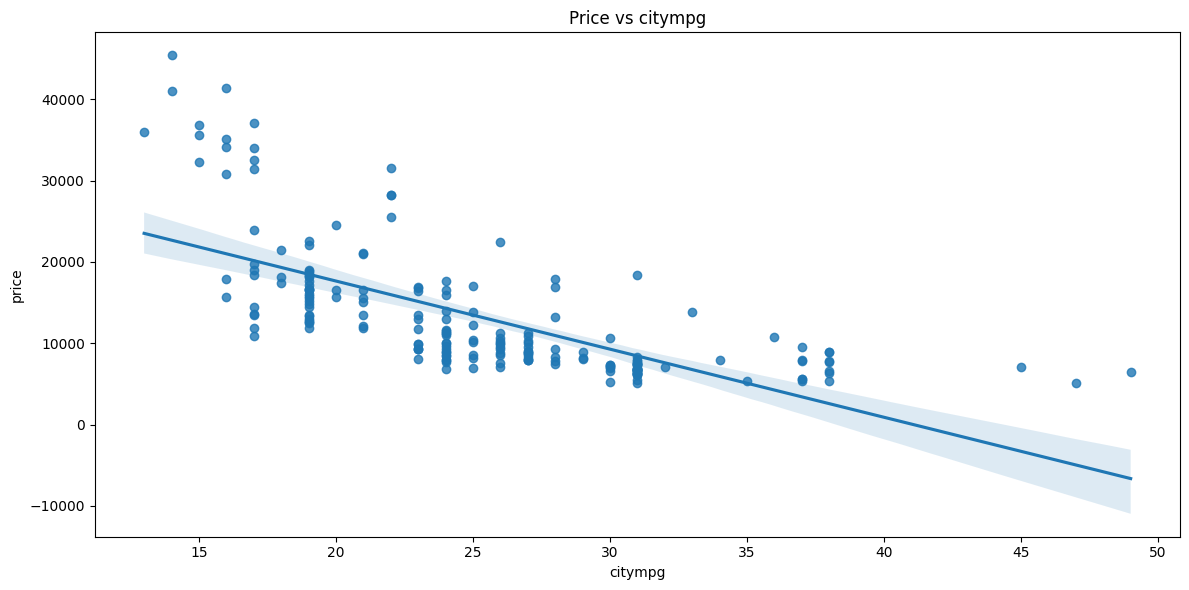

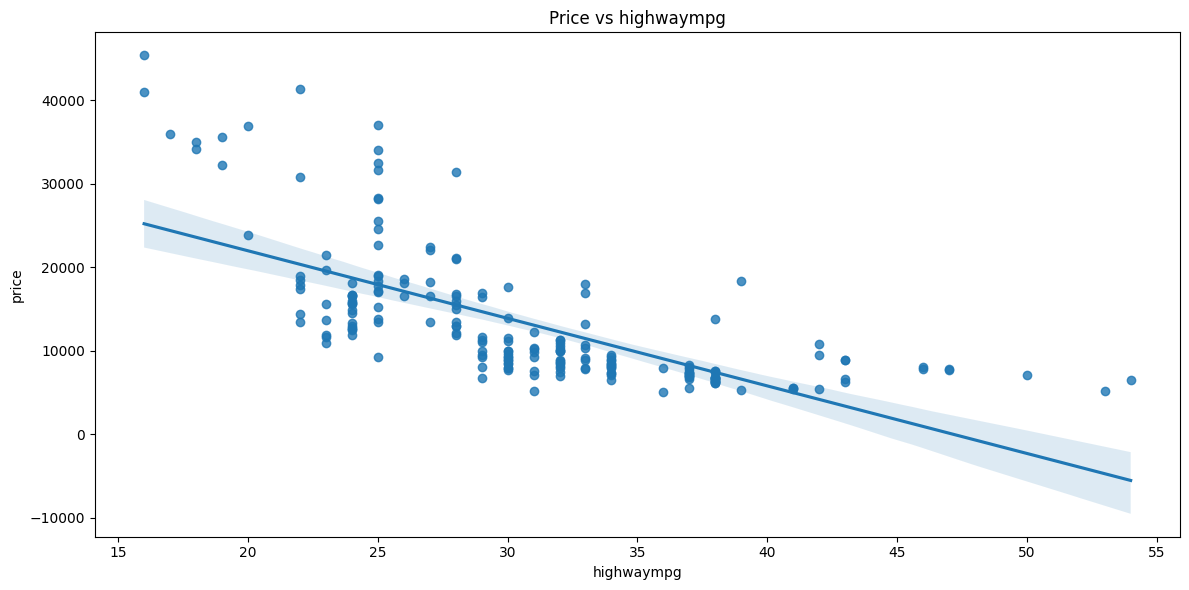

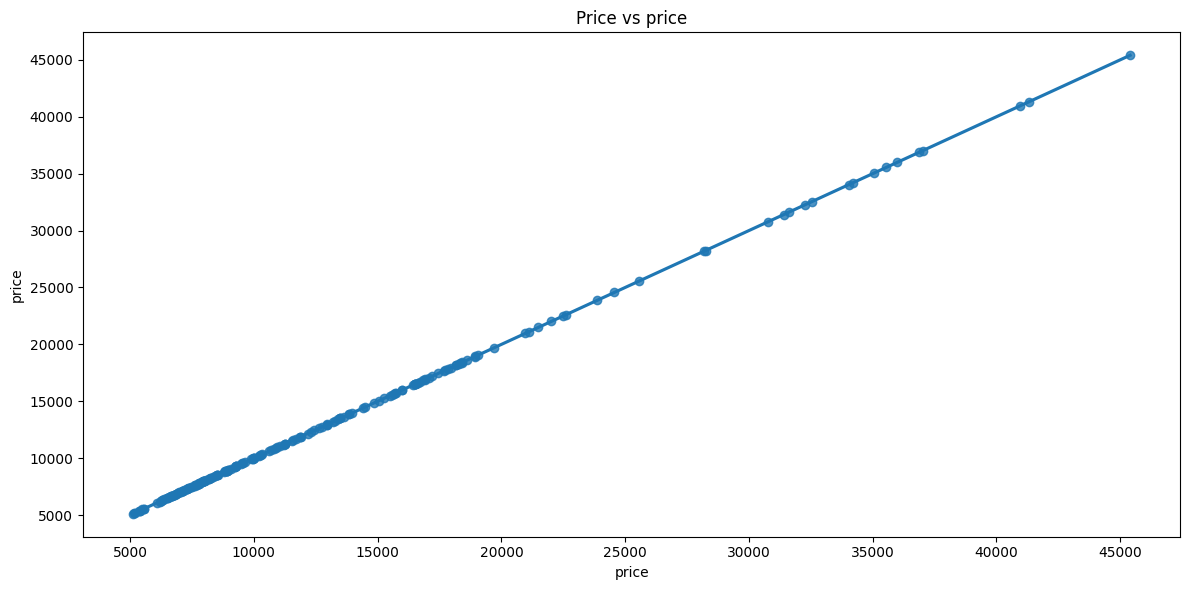

In [9]:
numeric_columns = data.select_dtypes(include = ['float64', 'int64']).columns
for col in numeric_columns:
    plt.figure(figsize=(12,6))
    sns.regplot(x=col, y='price', data=data)
    plt.title(f'Price vs {col}')
    plt.tight_layout()
    plt.show()
   

### Numeric Features vs Price

- **Horsepower, enginesize, curbweight, carlength, and carwidth** show strong positive correlations with price — larger, more powerful cars tend to be more expensive.
- **CityMPG and highwayMPG** have a clear **negative relationship** with price — fuel-efficient cars are generally cheaper.
- **PeakRPM and stroke** show **little to no correlation** with price and may be excluded from modeling.

Overall, vehicle size, weight, and engine specs are strong predictors of price, while efficiency metrics show an inverse trend.


Explore relationships between features and price using  correlation analysis


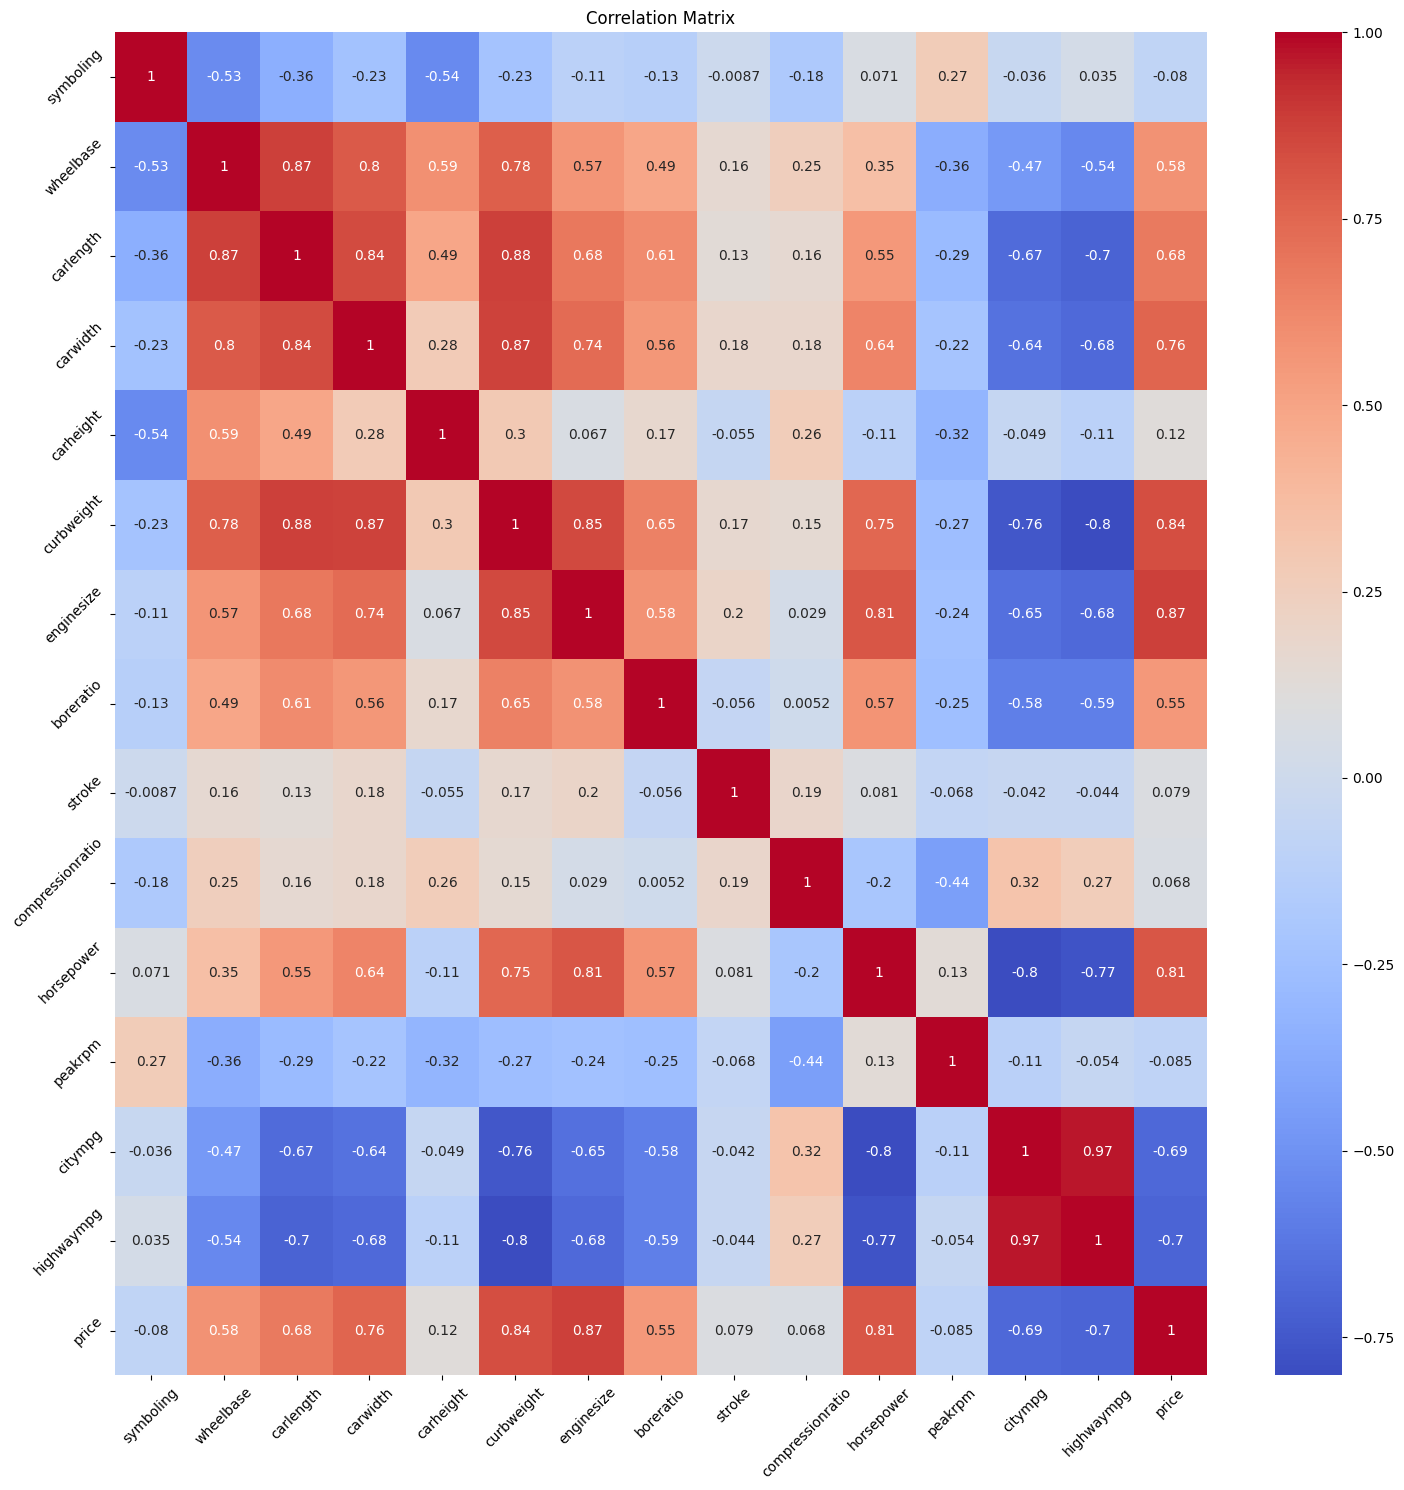

In [10]:
correlation_matrix = data.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [11]:
corr_matrix = data.select_dtypes(include=['int64', 'float64']).corr()
# df.select_dtypes(include=['int64', 'float64'])
corr_matrix['price'].sort_values(ascending=False)

price               1.000000
enginesize          0.874145
curbweight          0.835305
horsepower          0.808139
carwidth            0.759325
carlength           0.682920
wheelbase           0.577816
boreratio           0.553173
carheight           0.119336
stroke              0.079443
compressionratio    0.067984
symboling          -0.079978
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
Name: price, dtype: float64

###  Correlation Analysis

- **Price** has strong positive correlation with:
  - `enginesize` (**0.87**)
  - `curbweight` (**0.84**)
  - `horsepower` (**0.81**)
  - `carwidth` (**0.76**)
  - `carlength` (**0.68**)

- It has **strong negative correlation** with:
  - `citympg` (**-0.70**)
  - `highwaympg` (**-0.71**)

- Features like `peakrpm`, `stroke`, and `compressionratio` show **weak or no correlation** with price.

 These results confirm what we saw in the regression plots: performance and size-related features are key drivers of price, while fuel efficiency is inversely related. We'll prioritize these in feature selection.


In [ ]:
# Columns to remove based on weak correlation
cols_to_drop = [
    'symboling',
    'peakrpm',
    'stroke',
    'compressionratio'
]

# Drop them
data = data.drop(columns=cols_to_drop)

rand_typos = [
    'CarBrand_maxda',
    'CarBrand_toyouta',
    'CarBrand_vokswagen',
    'CarBrand_vw',
    'CarBrand_porcshce'
]

# Drop from DataFrame
data = data.drop(columns=rand_typos)

# Check result
print(f"Remaining columns: {data.shape[1]}")



Clean and encode categorical features: standardize text and convert to numeric values


In [12]:
data['doornumber'] = data['doornumber'].str.lower().str.strip()
data['doornumber'] = data['doornumber'].map({'two': 2, 'four': 4})
data['doornumber'] = data['doornumber'].astype(int)


In [13]:
# fueltype: gas=0, diesel=1
data['fueltype'] = data['fueltype'].map({'gas': 0, 'diesel': 1}).astype(int)

# aspiration: std=0, turbo=1
data['aspiration'] = data['aspiration'].map({'std': 0, 'turbo': 1}).astype(int)

# enginelocation: front=0, rear=1
data['enginelocation'] = data['enginelocation'].map({'front': 0, 'rear': 1}).astype(int)

# Check result
print(data[['fueltype','aspiration','enginelocation']].head(10))


   fueltype  aspiration  enginelocation
0         0           0               0
1         0           0               0
2         0           0               0
3         0           0               0
4         0           0               0
5         0           0               0
6         0           0               0
7         0           0               0
8         0           1               0
9         0           1               0


In [14]:
# Example column: cylindernumber
data['cylindernumber'] = data['cylindernumber'].str.lower().str.strip()  # clean text

# Map words to integers
num_map = {
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'eight': 8,
    'twelve': 12
}

data['cylindernumber'] = data['cylindernumber'].map(num_map)

# Convert to int (optional if you want to be sure)
data['cylindernumber'] = data['cylindernumber'].astype(int)

# Check result
print(data['cylindernumber'].unique())


[ 4  6  5  3 12  2  8]


In [15]:
# List of columns to encode
cat_cols = ['CarBrand', 'carbody', 'drivewheel', 'enginetype', 'fuelsystem']

# Convert text categories into binary columns
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fueltype              205 non-null    int64  
 1   aspiration            205 non-null    int64  
 2   doornumber            205 non-null    int64  
 3   enginelocation        205 non-null    int64  
 4   wheelbase             205 non-null    float64
 5   carlength             205 non-null    float64
 6   carwidth              205 non-null    float64
 7   carheight             205 non-null    float64
 8   curbweight            205 non-null    int64  
 9   cylindernumber        205 non-null    int64  
 10  enginesize            205 non-null    int64  
 11  boreratio             205 non-null    float64
 12  horsepower            205 non-null    int64  
 13  citympg               205 non-null    int64  
 14  highwaympg            205 non-null    int64  
 15  price                 2

Separate target variable (price) from the feature set


In [18]:
y = data['price']
X = data.drop('price', axis = 1)

Split dataset into training and testing sets (train_test_split).

In [19]:
X_train ,X_test, y_train ,y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)
# Print the shape of the splits
print(f"Train features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train features shape: (164, 56)
Test features shape: (41, 56)
Train labels shape: (164,)
Test labels shape: (41,)


Scale numerical features using StandardScaler to normalize X_train and X_test


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##  Model Training & Evaluation

We experimented with a variety of regression models to predict car prices and compared their performance using multiple evaluation metrics:

- **Linear Regression**
- **Ridge Regression**
- **Lasso Regression**
- **Decision Tree**
- **Random Forest**
- **Gradient Boosting**

### Evaluation Metrics

To assess model performance, we used the following metrics:
- **MAE**: Mean Absolute Error
- **MSE**: Mean Squared Error
- **RMSE**: Root Mean Squared Error
- **R² Score**: Proportion of variance explained by the model

All metrics were calculated on both **training and test sets**, and results were stored in a central DataFrame for comparison.


In [21]:
def error_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    errors = {}
    
    # Errors for train data
    errors["Train_MAE"] = mean_absolute_error(y_train_true, y_train_pred)
    errors["Train_MSE"] = mean_squared_error(y_train_true, y_train_pred)
    errors["Train_RMSE"] = np.sqrt(errors["Train_MSE"])
    errors["Train_R2_Score"] = r2_score(y_train_true, y_train_pred)
    
    # Errors for test data
    errors["Test_MAE"] = mean_absolute_error(y_test_true, y_test_pred)
    errors["Test_MSE"] = mean_squared_error(y_test_true, y_test_pred)
    errors["Test_RMSE"] = np.sqrt(errors["Test_MSE"])
    errors["Test_R2_Score"] = r2_score(y_test_true, y_test_pred)
    
    return errors

model_evaluation = []

Linear Regression

In [22]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

error_lr = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_lr['Model Name']='Linear Regression'
error_lr

model_evaluation = pd.DataFrame([error_lr])
model_evaluation


,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,984.528336,1.844485e+06,1358.118135,0.969072,1976.713607,9.276288e+06,3045.699868,0.882495,Linear Regression


In [23]:
# 1. Get feature importance (coefficients)
lr_coefficients = lr.coef_
lr_features = X_train.columns

# 2. Create DataFrame
lr_importance = pd.DataFrame({
    'Feature': lr_features,
    'Coefficient': lr_coefficients
})

# 3. Add absolute value for sorting
lr_importance['AbsCoefficient'] = lr_importance['Coefficient'].abs()

# 4. Sort by importance
lr_importance = lr_importance.sort_values(by='AbsCoefficient', ascending=False)

# 5. Show top 10
lr_importance.head(10)


,Feature,Coefficient,AbsCoefficient
10,enginesize,2575.480268,2575.480268
8,curbweight,2149.411015,2149.411015
17,CarBrand_bmw,1627.587554,1627.587554
18,CarBrand_buick,1591.060251,1591.060251
6,carwidth,1586.705800,1586.705800
3,enginelocation,1552.852356,1552.852356
5,carlength,-1504.701867,1504.701867
38,carbody_hatchback,-1451.548170,1451.548170
39,carbody_sedan,-1318.652899,1318.652899
4,wheelbase,960.371887,960.371887


The Linear Regression model estimates how much the car price changes per unit increase in each feature. Based on the absolute values of the coefficients, the most influential features are:

| Feature            | Coefficient |
|--------------------|-------------|
| `enginesize`       | +2575.48    |
| `curbweight`       | +2149.41    |
| `CarBrand_bmw`     | +1627.59    |
| `CarBrand_buick`   | +1591.06    |
| `carwidth`         | +1586.71    |
| `enginelocation`   | +1552.85    |

- Larger engine size and heavier weight significantly increase car price.
- Luxury brands like **BMW** and **Buick** contribute strongly to higher pricing.
- Features like **car width** and **engine location** also influence price, which makes sense because they affect performance and design.


Ridge Regression

In [24]:
pipe = Pipeline([
    ('scale',StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('model', Ridge())
])
pipe
param_grid = {'model__alpha': [0.01, 0.1, 1, 10, 100],
    'poly__degree': [1, 2, 3, 4]
}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model_ridge = grid_search.best_estimator_
print(best_model_ridge)

Pipeline(steps=[('scale', StandardScaler()),
                ('poly', PolynomialFeatures(degree=1)),
                ('model', Ridge(alpha=10))])


In [25]:
y_train_pred = best_model_ridge.predict(X_train)
y_test_pred = best_model_ridge.predict(X_test)

error_Ridge = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_Ridge['Model Name']='Ridge'
error_Ridge
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_Ridge]))], ignore_index=True)
model_evaluation

,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,984.528336,1.844485e+06,1358.118135,0.969072,1976.713607,9.276288e+06,3045.699868,0.882495,Linear Regression
1,1059.718969,2.183527e+06,1477.676371,0.963387,2161.974031,1.013300e+07,3183.237358,0.871643,Ridge



Lasso

In [26]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('model', Lasso())
])
pipe

param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100],
    'poly__degree': [1, 2, 3]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model_lasso = grid_search.best_estimator_
print(best_model_lasso)

Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures()),
                ('model', Lasso(alpha=10))])


In [27]:

y_train_pred = best_model_lasso.predict(X_train_scaled)
y_test_pred = best_model_lasso.predict(X_test_scaled)
error_Lasso = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_Lasso['Model Name']='Lasso'
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_Lasso]))], ignore_index=True)
model_evaluation

,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,984.528336,1.844485e+06,1358.118135,0.969072,1976.713607,9.276288e+06,3045.699868,0.882495,Linear Regression
1,1059.718969,2.183527e+06,1477.676371,0.963387,2161.974031,1.013300e+07,3183.237358,0.871643,Ridge
2,182989.911836,5.421632e+10,232843.971922,-908.092577,145461.958127,2.405436e+10,155094.688482,-303.701510,Lasso


Decision Trees



In [28]:
mod_tree = DecisionTreeRegressor(random_state=42)

param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': np.arange(1,10),
    
}

grid_search = GridSearchCV(mod_tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
best_tree = grid_search.best_estimator_
print(best_tree)


DecisionTreeRegressor(criterion='absolute_error', max_depth=np.int64(9),
                      random_state=42)


In [29]:

y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

error_tree = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_tree['Model Name'] = 'Decision Tree'
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_tree]))], ignore_index=True)
model_evaluation

,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,984.528336,1.844485e+06,1358.118135,0.969072,1976.713607,9.276288e+06,3045.699868,0.882495,Linear Regression
1,1059.718969,2.183527e+06,1477.676371,0.963387,2161.974031,1.013300e+07,3183.237358,0.871643,Ridge
2,182989.911836,5.421632e+10,232843.971922,-908.092577,145461.958127,2.405436e+10,155094.688482,-303.701510,Lasso
3,270.804878,4.700828e+05,685.625851,0.992118,1858.784561,7.408864e+06,2721.922884,0.906150,Decision Tree


Random Forest



In [30]:
random_forest = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['squared_error', 'friedman_mse',],
    'max_depth': np.arange(1,10),
    'min_samples_split': np.arange(1,10)
}

grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
best_forest = grid_search.best_estimator_
print(best_forest)

RandomForestRegressor(criterion='friedman_mse', max_depth=np.int64(9),
                      min_samples_split=np.int64(2))


In [31]:
y_train_pred = best_forest.predict(X_train)
y_test_pred = best_forest.predict(X_test)

error_random_forest = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_random_forest['Model Name'] = 'Random Forest'
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_random_forest]))], ignore_index=True)
model_evaluation

,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,984.528336,1.844485e+06,1358.118135,0.969072,1976.713607,9.276288e+06,3045.699868,0.882495,Linear Regression
1,1059.718969,2.183527e+06,1477.676371,0.963387,2161.974031,1.013300e+07,3183.237358,0.871643,Ridge
2,182989.911836,5.421632e+10,232843.971922,-908.092577,145461.958127,2.405436e+10,155094.688482,-303.701510,Lasso
3,270.804878,4.700828e+05,685.625851,0.992118,1858.784561,7.408864e+06,2721.922884,0.906150,Decision Tree
4,650.818080,1.006745e+06,1003.367073,0.983119,1308.275108,3.531294e+06,1879.173814,0.955268,Random Forest


In [32]:
# Create a DataFrame for feature importances
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_forest.feature_importances_
})

# Sort by importance
rf_importance = rf_importance.sort_values(by='Importance', ascending=False)

# Show top 10
rf_importance.head(10)


,Feature,Importance
10,enginesize,0.568840
8,curbweight,0.266715
14,highwaympg,0.046314
12,horsepower,0.044030
6,carwidth,0.021345
17,CarBrand_bmw,0.009233
4,wheelbase,0.008641
5,carlength,0.007027
11,boreratio,0.005033
13,citympg,0.004631


The Random Forest model provides importance scores based on how much each feature decreases error across decision trees. The top predictors are:

| Feature            | Importance |
|--------------------|------------|
| `enginesize`       | 0.5688     |
| `curbweight`       | 0.2667     |
| `highwaympg`       | 0.0464     |
| `horsepower`       | 0.0440     |
| `carwidth`         | 0.0214     |
| `CarBrand_bmw`     | 0.0092     |

- Once again, **engine size** and **curb weight** dominate — confirming these are consistently powerful predictors.
- Unlike Linear Regression, **Random Forest also highlights `highwaympg` and `horsepower`**, which suggests non-linear relationships.
- Brand still matters, but less so in tree-based models.



Gradient Boosting Regressor

In [33]:
gbr = GradientBoostingRegressor()

param_grid_gbr = {
    'n_estimators': [100, 200, 300],              # number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2],      # shrinkage rate
    'max_depth': [2, 3, 4, 5],                    # depth of individual trees
    'min_samples_split': [2, 4, 6],               # minimum split for nodes
    'min_samples_leaf': [1, 2, 3]                 # minimum number of samples in leaves
}

grid_search_gbr = GridSearchCV(
    gbr,
    param_grid_gbr,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_gbr.fit(X_train, y_train)

best_gbr = grid_search_gbr.best_estimator_
print(best_gbr)

GradientBoostingRegressor(learning_rate=0.2, max_depth=5, min_samples_leaf=3,
                          n_estimators=200)


In [34]:
y_train_pred = best_gbr.predict(X_train)
y_test_pred = best_gbr.predict(X_test)

error_random_gbr = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_random_gbr['Model Name'] = 'GradientBoostingRegressor'
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_random_gbr]))], ignore_index=True)
model_evaluation

,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,984.528336,1.844485e+06,1358.118135,0.969072,1976.713607,9.276288e+06,3045.699868,0.882495,Linear Regression
1,1059.718969,2.183527e+06,1477.676371,0.963387,2161.974031,1.013300e+07,3183.237358,0.871643,Ridge
2,182989.911836,5.421632e+10,232843.971922,-908.092577,145461.958127,2.405436e+10,155094.688482,-303.701510,Lasso
3,270.804878,4.700828e+05,685.625851,0.992118,1858.784561,7.408864e+06,2721.922884,0.906150,Decision Tree
4,650.818080,1.006745e+06,1003.367073,0.983119,1308.275108,3.531294e+06,1879.173814,0.955268,Random Forest
5,84.363636,7.530349e+04,274.414820,0.998737,1723.155097,6.813451e+06,2610.258857,0.913693,GradientBoostingRegressor


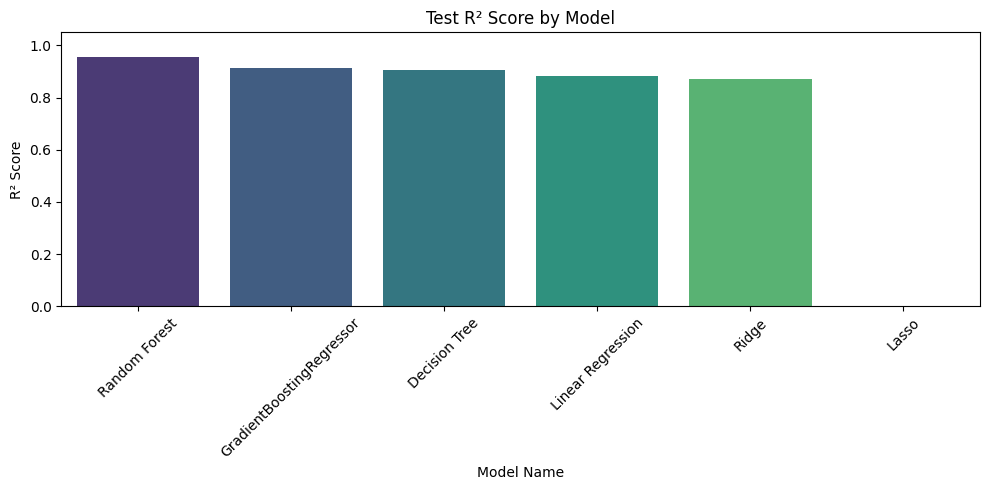

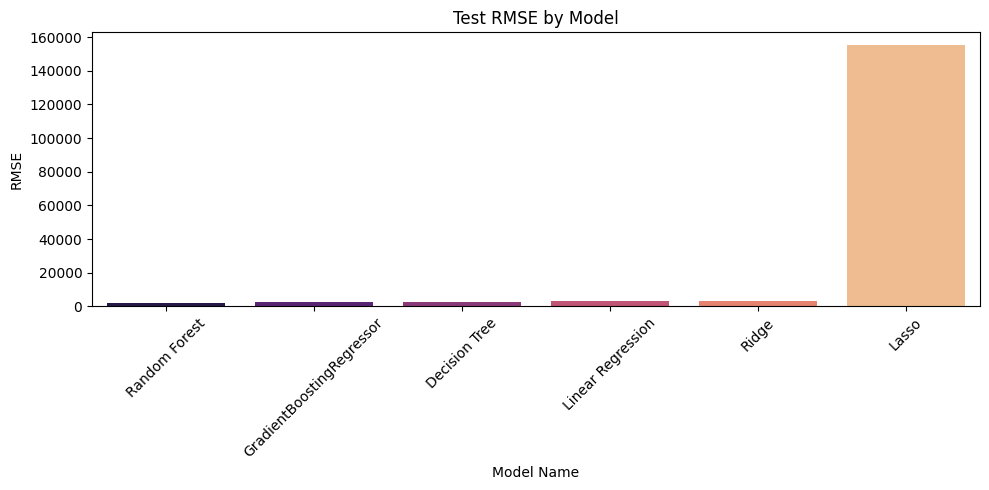

In [ ]:
plot_df = model_evaluation.sort_values(by='Test_R2_Score', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='Model Name', y='Test_R2_Score', data=plot_df, palette='viridis')
plt.title('Test R² Score by Model')
plt.xticks(rotation=45)
plt.ylabel('R² Score')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='Model Name', y='Test_RMSE', data=plot_df, palette='magma')
plt.title('Test RMSE by Model')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

## Model Comparison Results

Below is the comparison of all models based on their performance on both training and test sets.

| Model | Test RMSE ↓ | Test R² Score ↑ |
|-------|-------------|-----------------|
| Random Forest | 1879 | 0.955 |
| Gradient Boosting | 2610 | 0.914 |
| Linear Regression | 3045 | 0.882 |
| Ridge | 3183 | 0.872 |
| Decision Tree | 2721 | 0.906 |
| Lasso | - | -303.7 |

**Lasso** completely failed due to over-regularization.  
**Random Forest** had the best test performance and generalization.  
**Linear model** (LR, Ridge) performed decently but couldn't fully capture nonlinear patterns.


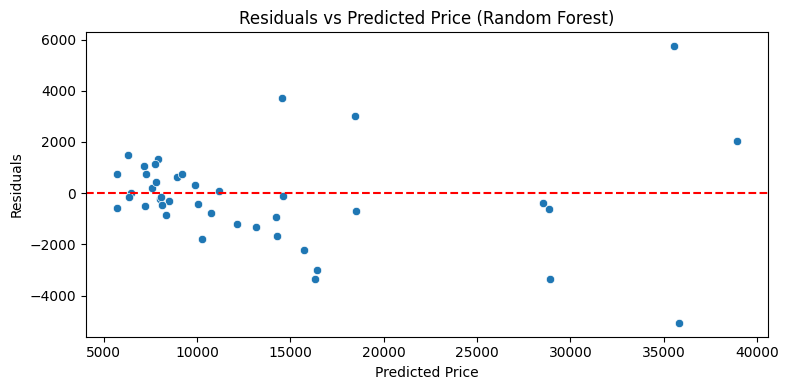

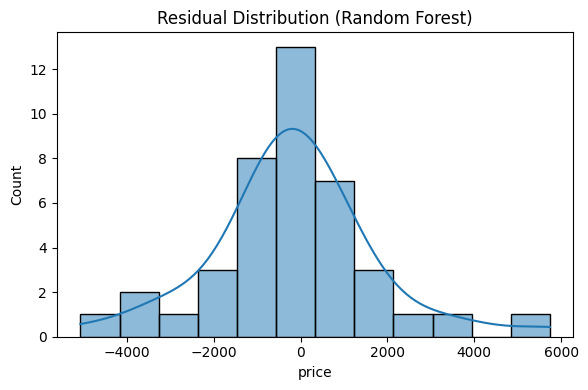

In [39]:

y_pred_rf = best_forest.predict(X_test)

residuals = y_test - y_pred_rf

# Residual plot
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Price (Random Forest)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Random Forest)")
plt.tight_layout()
plt.show()



- The residuals are mostly centered around 0 and randomly scattered, indicating **no obvious patterns** or heteroscedasticity — a good sign of model generalization.
- The distribution of residuals is close to **normal**, which confirms that errors are randomly distributed.
- A few larger residuals exist for **high-priced cars**, meaning the model slightly underestimates expensive vehicles — possibly due to fewer high-end examples in the data.

Overall, the residual analysis confirms that the model is reliable and well-fitted to the data.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

scores = cross_val_score(best_forest, X_train, y_train, 
                         scoring='neg_root_mean_squared_error', cv=5)

rmse_scores = -scores
print("Cross-Validated RMSE:", rmse_scores)
print("Mean:", rmse_scores.mean(), "Std:", rmse_scores.std())


Cross-Validated RMSE: [2144.51994114 1526.21049115 3015.63665453 2021.04175394 3119.16485953]
Mean: 2365.3147400579846 Std: 610.3406864697457



- The model performs **consistently well across all folds**, with RMSEs mostly within the $1500–$3100 range.
- A standard deviation of ~$610 indicates **moderate variance**, which is acceptable for real-world regression tasks like car pricing.
- These results **reinforce** that our Random Forest model generalizes well and isn’t overfitting to specific subsets of the data.



# Final Summary & Business Interpretation

###  Project Goal
The objective of this project was to build a machine learning model to **predict car prices** based on various features like engine size, brand, fuel type, and dimensions. This can help:
- Consumers evaluate car prices fairly
- Dealerships automate pricing
- Platforms like Carvana or OLX improve recommendations

---

###  Best Model: **Random Forest Regressor**

| Metric | Train RMSE | Test RMSE | R² Score (Test) |
|--------|------------|-----------|-----------------|
| Random Forest | ~1003 | **~1879** | **0.955** |

- High R² on test set: 95.5% of price variance explained.
- Cross-validated RMSE: **$2365 ± $610**, indicating good generalization.
-  Performs significantly better than linear models on this non-linear problem.

---

### Key Features Impacting Price:
From feature importance analysis:
- `enginesize`, `curbweight`, and `horsepower` had the **highest positive influence** on price.
- Premium brands like **BMW**, **Porsche**, and **Jaguar** were also strongly predictive.

---

###  Residual Analysis:
- Residuals were **randomly distributed** around zero — no signs of bias.
- Error spread was larger for **high-priced cars**, likely due to fewer examples.

---

### Final Takeaways:
- The model performs strongly and is robust to new data.
- Feature and residual analysis confirm **reliability** and **business relevance**.
- This solution could be deployed in a pricing API or car marketplace engine.


